# Find the best estimator for Ecorr potetial value

It always requires a lot of time and resources to make a new product for a specific engineering design. Ecorr value is always an important value to show if the final product passes the quality control. Over the years, we have produced an enormous amount of materials and we have measured individually compositional profile and Ecorr value for each of them. ML will help to use all of this knowledge to predict the future product Ecorr value without the need to trail production. This would save much time and resources.

## project objective 

This project will try to find the best model for Ecorr prediction which would be the basis for finding a relation between the microstructure and corrosion resistance properties of our products.

In [298]:
# in this project, linear and polynomial linear regression are the base models
# in addition used Random forest, Lasso and Ridge regression
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import pickle
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [299]:
df = pd.read_excel('ecorr_raw_data.xls')

## Sample Data

A sample of 6000 measurements was selected, some did not have Ecorr values.

In [301]:
df

,Proj no.,TO no.,Coil no.,Sample no.,WS,Brazed,Depth [μm],Unit,Al,Si,...,In,Li,Na,P,Pb,Sn,Sr,V,Zr,Ecorr[mV]
0,G17-0054,432431,S02798,P18-00305BL,0,1,0.1466,m%,65.02,26.694,...,0.000,0.0,0.1797,0.0121,0.610,0.473,0.6694,0.078,0.031,-720.01919
1,G17-0054,432431,S02798,P18-00305BL,0,1,0.2875,m%,58.17,39.426,...,0.000,0.0,0.0033,0.0024,0.013,0.068,0.0372,0.022,0.010,-719.661113
2,G17-0054,432431,S02798,P18-00305BL,0,1,0.4333,m%,58.95,39.146,...,0.000,0.0,0.0009,0.0022,0.006,0.043,0.0156,0.017,0.008,-719.300728
3,G17-0054,432431,S02798,P18-00305BL,0,1,0.5772,m%,61.44,36.913,...,0.000,0.0,0.0002,0.0021,0.001,0.032,0.0093,0.014,0.003,-718.955004
4,G17-0054,432431,S02798,P18-00305BL,0,1,0.7262,m%,65.58,32.960,...,0.000,0.0,0.0000,0.0021,0.010,0.016,0.0068,0.013,0.003,-718.607299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,G18-0053,430440,S013541,P18-00208-LS-S1,0,1,121.6161,m%,97.25,0.218,...,0.003,0.0,0.0015,0.0019,0.043,0.019,0.0002,0.011,0.003,-691.035983
5996,G18-0053,430440,S013541,P18-00208-LS-S1,0,1,121.7364,m%,97.22,0.223,...,0.004,0.0,0.0016,0.0019,0.051,0.015,0.0003,0.012,0.002,-691.03055
5997,G18-0053,430440,S013541,P18-00208-LS-S1,0,1,121.8569,m%,97.21,0.218,...,0.004,0.0,0.0016,0.0019,0.045,0.022,0.0004,0.012,0.008,-691.025113
5998,G18-0053,430440,S013541,P18-00208-LS-S1,0,1,121.9775,m%,97.21,0.219,...,0.005,0.0,0.0016,0.0019,0.046,0.023,0.0003,0.010,0.007,-691.019678


In [9]:
# removed Ecorr rows withou values
df_Ecorr_Value = df[df['Ecorr[mV]'] != 'NAN']

In [10]:
# remaining 5212 sample data
df_Ecorr_Value.shape

(5212, 36)

In [15]:
df_Ecorr_Value['Ecorr[mV]'].values

array([-720.01918974, -719.66111334, -719.30072778, ..., -691.02511313,
       -691.01967752, -691.01424885])

In [17]:
df_Ecorr_Value.columns

Index(['Proj no.', 'TO no.', 'Coil no.', 'Sample no.', 'WS', 'Brazed',
       'Depth [μm]', 'Unit', 'Al', 'Si', 'Fe', 'Cu', 'Mn', 'Mg', 'Cr', 'Ni-L',
       'Ni-H', 'Zn', 'Ti', 'B', 'Be', 'Bi', 'Ca', 'Cd', 'Ga', 'Hg', 'In', 'Li',
       'Na', 'P', 'Pb', 'Sn', 'Sr', 'V', 'Zr', 'Ecorr[mV]'],
      dtype='object')

In [20]:
df_model = df_Ecorr_Value[['Al', 'Si', 'Fe', 'Cu', 'Mn', 'Mg', 'Cr', 'Ni-L',
       'Zn', 'Ti', 'B', 'Be', 'Bi', 'Ca', 'Cd', 'Ga', 'Hg', 'In', 
       'Na', 'P', 'Pb', 'Sn', 'Sr', 'V', 'Zr', 'Ecorr[mV]']]

In [29]:
df_model = df_model.apply(pd.to_numeric, errors='coerce')

## Material description

Material description
Our material sample data is as expected Aluminum base alloy with minimum Al content of 58% and maximum content 98%. It is possible to see min and max value content for different alloying elements.
Al min 58.17 - max 97.99
Si min 0.041 - max 39.426
Fe min 0.036 - max 1.558
Cu min 0.038 - max 0.557
Mn min 0.056 - max 1.82
Mg min 0.0 - max 14.967
Cr min 0.0 - max 0.01
Ni-L min 0.003 - max 0.088
Zn min 0.0 - max 1.308
Ti min 0.0 - max 0.183
B min 0.0 - max 0.0202
Be min 0.0 - max 0.0065
Bi min 0.0 - max 2.086
Ca min 0.0 - max 0.1771
Cd min 0.0 - max 0.064
Ga min 0.0 - max 0.025
Hg min 0.0 - max 0.0757
In min 0.0 - max 0.005
Na min 0.0 - max 0.1797
P min 0.0019 - max 0.0157
Pb min 0.0 - max 0.61
Sn min 0.0 - max 0.875
Sr min 0.0 - max 0.7143
V min 0.001 - max 0.148
Zr min 0.0 - max 0.157
Ecorr[mV] min -753.68483162337 - max -674.628660623679

In [295]:
for i in df_model.columns:
    print(f'{i} min {df_model[i].min()} - max {df_model[i].max()}')

Al min 58.17 - max 97.99
Si min 0.041 - max 39.426
Fe min 0.036 - max 1.558
Cu min 0.038 - max 0.557
Mn min 0.056 - max 1.82
Mg min 0.0 - max 14.967
Cr min 0.0 - max 0.01
Ni-L min 0.003 - max 0.088
Zn min 0.0 - max 1.308
Ti min 0.0 - max 0.183
B min 0.0 - max 0.0202
Be min 0.0 - max 0.0065
Bi min 0.0 - max 2.086
Ca min 0.0 - max 0.1771
Cd min 0.0 - max 0.064
Ga min 0.0 - max 0.025
Hg min 0.0 - max 0.0757
In min 0.0 - max 0.005
Na min 0.0 - max 0.1797
P min 0.0019 - max 0.0157
Pb min 0.0 - max 0.61
Sn min 0.0 - max 0.875
Sr min 0.0 - max 0.7143
V min 0.001 - max 0.148
Zr min 0.0 - max 0.157
Ecorr[mV] min -753.68483162337 - max -674.628660623679


In [32]:
df_model.describe()

,Al,Si,Fe,Cu,Mn,Mg,Cr,Ni-L,Zn,Ti,...,Hg,In,Na,P,Pb,Sn,Sr,V,Zr,Ecorr[mV]
count,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.00000,5212.000000,5212.000000,5212.000000,5212.000000,...,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000
mean,96.408563,1.352391,0.192121,0.318446,1.270538,0.12174,0.000537,0.006419,0.118043,0.108004,...,0.000613,0.000473,0.000559,0.002120,0.027969,0.009533,0.000802,0.011148,0.029647,-697.871957
std,2.973611,3.147103,0.087681,0.170617,0.444255,0.25185,0.000632,0.002218,0.299506,0.057584,...,0.001838,0.000959,0.003770,0.000372,0.020159,0.023689,0.019948,0.005389,0.046293,17.257512
min,58.170000,0.041000,0.036000,0.038000,0.056000,0.00000,0.000000,0.003000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001900,0.000000,0.000000,0.000000,0.001000,0.000000,-753.684832
25%,96.440000,0.216000,0.143000,0.158000,1.340000,0.01800,0.000000,0.005000,0.008000,0.038000,...,0.000000,0.000000,0.000000,0.002000,0.020000,0.000000,0.000000,0.008000,0.000000,-711.335567
50%,97.060000,0.561500,0.215000,0.327000,1.407000,0.11300,0.000000,0.006000,0.014000,0.142000,...,0.000300,0.000000,0.000000,0.002100,0.031000,0.007000,0.000000,0.012000,0.004000,-693.032697
75%,97.260000,1.449000,0.228000,0.498000,1.472000,0.16900,0.001000,0.008000,0.021000,0.149000,...,0.000900,0.000000,0.001000,0.002200,0.038000,0.016000,0.000100,0.013000,0.046000,-683.377955
max,97.990000,39.426000,1.558000,0.557000,1.820000,14.96700,0.010000,0.088000,1.308000,0.183000,...,0.075700,0.005000,0.179700,0.015700,0.610000,0.875000,0.714300,0.148000,0.157000,-674.628661


 ## Histogram Analysis
 
This shows our alloys mostly contain more than 95% Al. Si, Fe, Cu, Mn, Cr, Zn, Ti, Ga, Zr are the most important alloying elements. B, Be, Bi, Ca, Cd, Hg, Na, P, Pb, Sn, Sr are trace elements.
The Ecorr potential value as target value is covering a good amount of the values in this sample model.
It is good to have more sample measurements for Mg and Sr alloys, due to having these alloys as active production alloys. It is recommended to add more sample data for the low potential range.

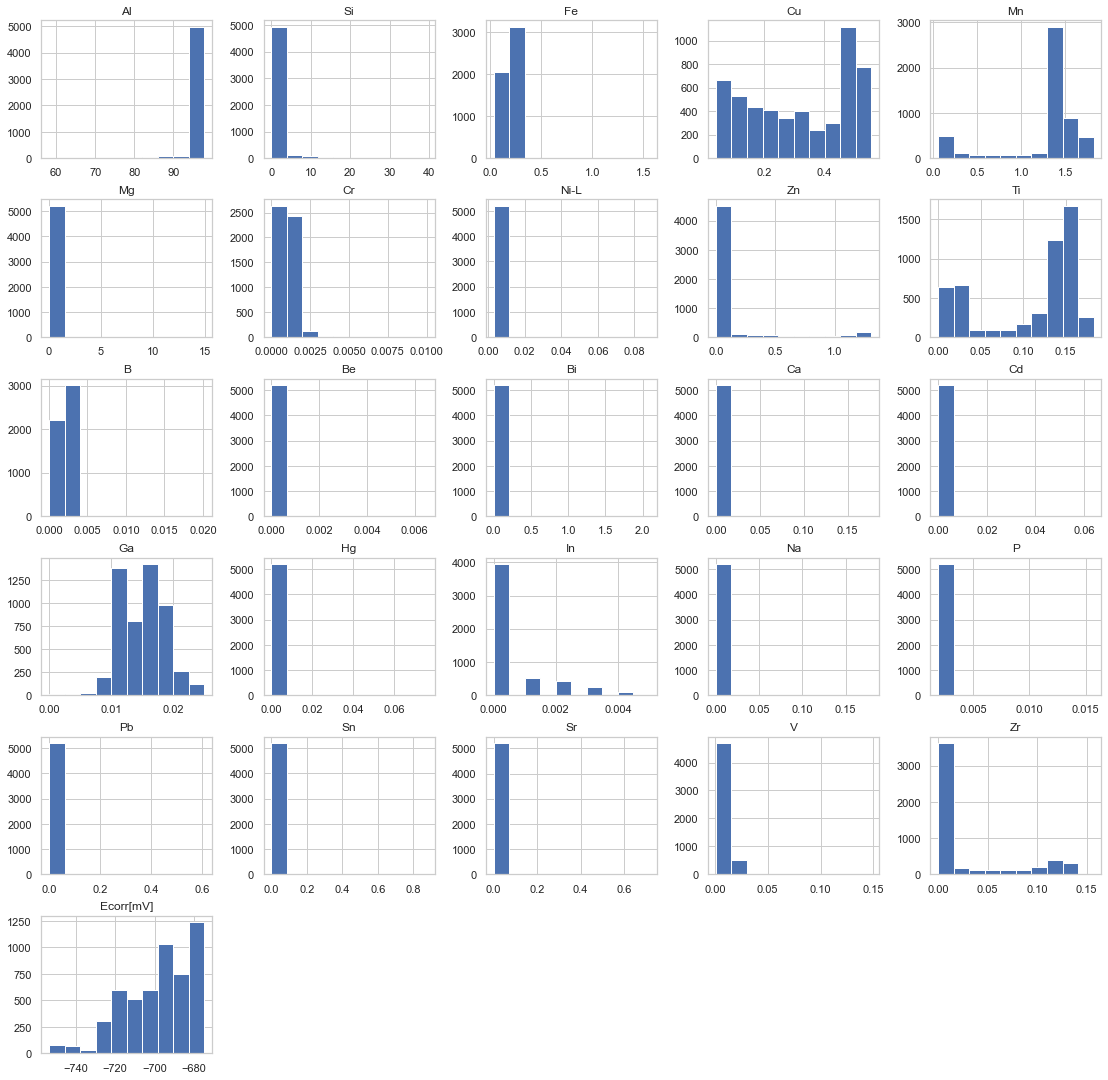

In [304]:
fig = plt.figure(figsize = (19,19))
ax = fig.gca()
df_model.hist(ax = ax)
plt.show()

# Ecorr potential

Ecorr value as the target value. It is a good distribution of the values with few out of sample data which is related to high Zn content alloys.

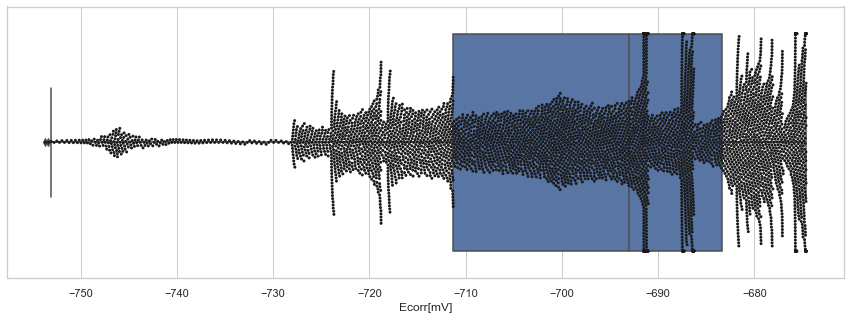

In [302]:
fig = plt.figure(figsize = (15,5))
ax = sns.boxplot(x=df_model['Ecorr[mV]'])
ax = sns.swarmplot(x=df_model['Ecorr[mV]'], size=3 ,color=".1")
plt.show()

In [94]:
df_model.corr()

,Al,Si,Fe,Cu,Mn,Mg,Cr,Ni-L,Zn,Ti,...,Hg,In,Na,P,Pb,Sn,Sr,V,Zr,Ecorr[mV]
Al,1.000000,-0.966081,-0.681104,0.285078,0.309888,-0.125378,-0.293770,-0.371846,-0.027888,0.391553,...,-0.491896,0.144804,-0.295293,-0.339665,0.033715,-0.308713,-0.388303,-0.257482,-0.040064,0.354439
Si,-0.966081,1.000000,0.551778,-0.403242,-0.502587,0.003979,0.261111,0.229231,-0.107360,-0.502164,...,0.395826,-0.175596,0.212455,0.234302,-0.206969,0.206866,0.303889,0.227315,-0.005384,-0.400899
Fe,-0.681104,0.551778,1.000000,0.001914,0.306768,0.008184,0.539496,0.405496,0.003088,0.015577,...,0.470962,0.165602,0.310970,0.250176,0.313354,0.422501,0.342746,0.479535,0.215387,-0.095195
Cu,0.285078,-0.403242,0.001914,1.000000,0.387531,0.232276,0.100644,0.072009,-0.029162,0.826429,...,-0.116334,0.477345,0.038668,-0.022266,0.476994,0.054852,-0.037848,-0.284200,-0.587235,0.814088
Mn,0.309888,-0.502587,0.306768,0.387531,1.000000,0.018519,0.065725,0.195683,0.212018,0.530747,...,-0.000269,0.135343,-0.007779,-0.040288,0.503294,0.063812,-0.061782,0.047409,0.363893,0.285263
Mg,-0.125378,0.003979,0.008184,0.232276,0.018519,1.000000,-0.024797,0.367391,0.125953,0.143912,...,0.308748,-0.024630,0.333870,0.488776,0.496771,0.438024,0.389489,0.066888,-0.152545,0.123478
Cr,-0.293770,0.261111,0.539496,0.100644,0.065725,-0.024797,1.000000,0.065587,-0.289095,0.101723,...,0.339394,0.387218,0.373524,0.170168,0.348959,0.468295,0.326025,0.454330,-0.050302,0.122401
Ni-L,-0.371846,0.229231,0.405496,0.072009,0.195683,0.367391,0.065587,1.000000,0.242542,0.081435,...,0.658199,-0.129577,0.637748,0.695964,0.529380,0.576583,0.647194,0.350261,0.006396,0.101902
Zn,-0.027888,-0.107360,0.003088,-0.029162,0.212018,0.125953,-0.289095,0.242542,1.000000,-0.132906,...,0.053372,-0.162788,-0.025076,0.171016,0.005455,-0.086943,0.001985,-0.179170,0.248703,-0.357580
Ti,0.391553,-0.502164,0.015577,0.826429,0.530747,0.143912,0.101723,0.081435,-0.132906,1.000000,...,-0.137867,0.338498,0.009081,-0.028121,0.436768,0.058112,-0.068015,-0.277854,-0.458198,0.853389


In [95]:
df_model.corr()['Ecorr[mV]']

Al           0.354439
Si          -0.400899
Fe          -0.095195
Cu           0.814088
Mn           0.285263
Mg           0.123478
Cr           0.122401
Ni-L         0.101902
Zn          -0.357580
Ti           0.853389
B            0.658954
Be          -0.085850
Bi          -0.120013
Ca           0.006092
Cd          -0.059585
Ga           0.704611
Hg          -0.159050
In           0.337260
Na           0.017895
P           -0.077671
Pb           0.427688
Sn           0.035667
Sr          -0.052941
V           -0.237506
Zr          -0.629409
Ecorr[mV]    1.000000
Name: Ecorr[mV], dtype: float64

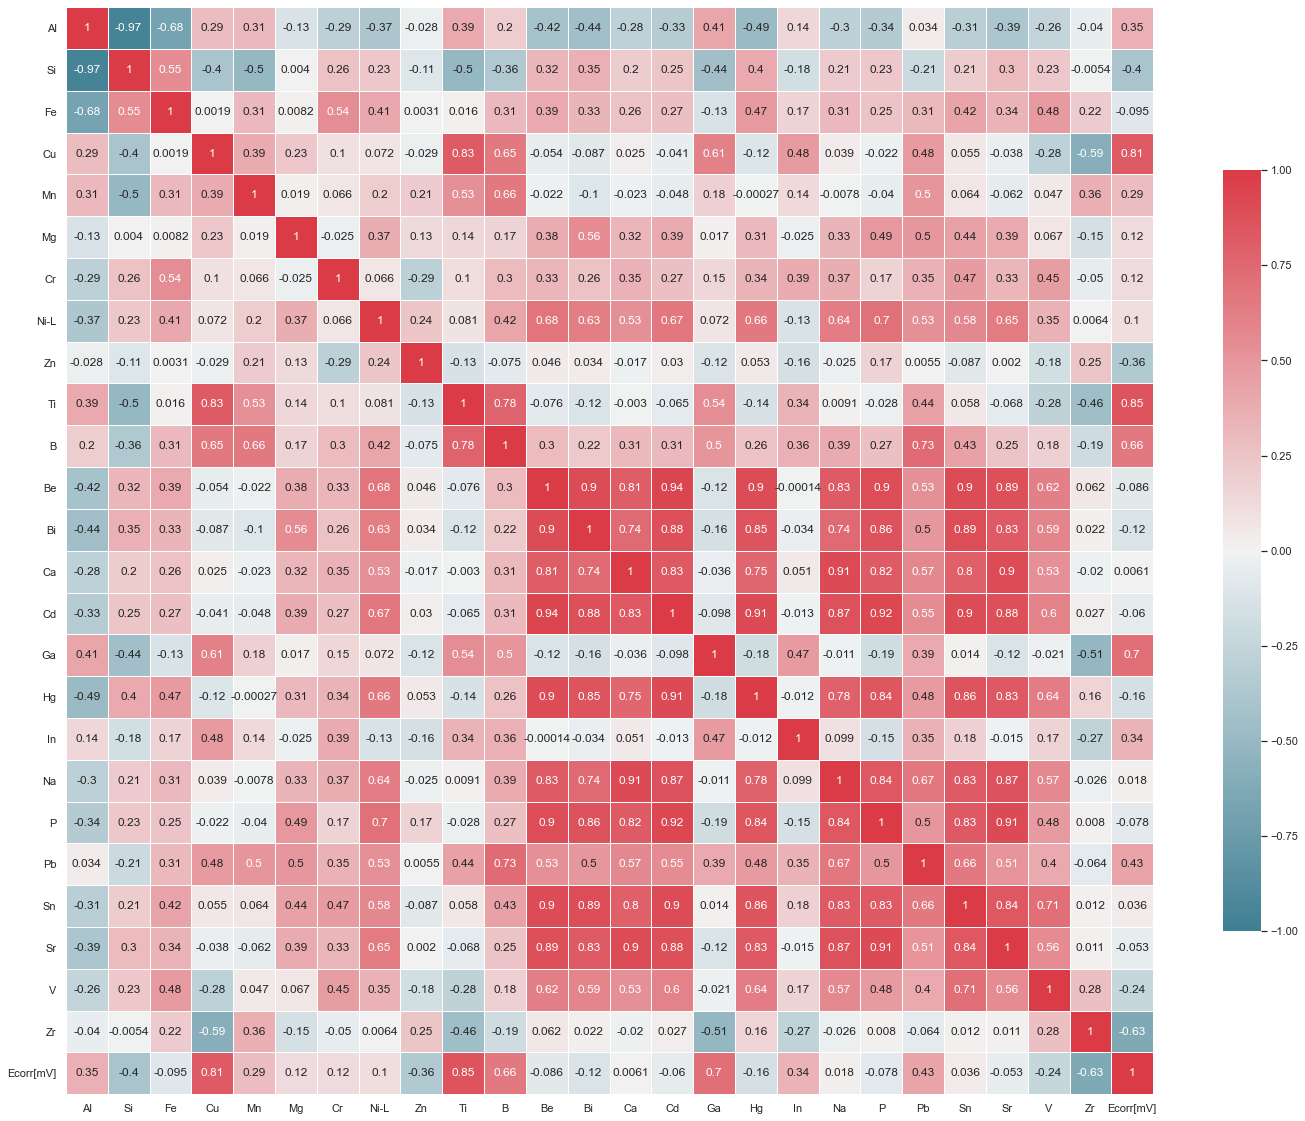

In [127]:
fig = plt.figure(figsize = (25,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_model.corr(), cmap=cmap, square= True, linewidths= 0.5, annot=True, cbar_kws={"shrink": .7}, vmin= -1, vmax=1)
plt.yticks(rotation=0) 
plt.show()

In [130]:
df.to_csv('raw_data_csv_format.csv')
df_model.to_csv('df_model.csv')

# Non relevant elements

The elements like Ca, Cd, Na, and Sn are removed from the model data frame. Because these are categorized as trace elements and they do not show a high correlation with the Ecorr value.

In [144]:
df_model.columns

Index(['Al', 'Si', 'Fe', 'Cu', 'Mn', 'Mg', 'Cr', 'Ni-L', 'Zn', 'Ti', 'B', 'Be',
       'Bi', 'Ca', 'Cd', 'Ga', 'Hg', 'In', 'Na', 'P', 'Pb', 'Sn', 'Sr', 'V',
       'Zr', 'Ecorr[mV]'],
      dtype='object')

In [145]:
df_model_reg = df_model[['Al', 'Si', 'Fe', 'Cu', 'Mn', 'Mg', 'Cr', 'Ni-L', 'Zn', 'Ti', 'B', 'Be',
       'Bi', 'Ga', 'Hg', 'In', 'P', 'Pb', 'Sr', 'V', 'Zr', 'Ecorr[mV]']]

# Most relevant elements

The most correlated elements are Cu, Mn, Zn, Ti, B, Ga, Pb, Zr. It is well-known that elements like Cu, Zn, and Mn are affecting the Ecorr value by dissolving in solid solution and altering the Ecorr value. All the selected elements show statistically be significant.

In [159]:
for i in df_model_reg.columns:
    if i != 'Ecorr[mV]':
        pearson_coef, p_value = stats.pearsonr(df_model_reg[i], df_model_reg['Ecorr[mV]'])
        print(f'{i} >>> The Pearson Correlation Coefficient is {pearson_coef} and with a P-value of P ={p_value}')
        if p_value <= 0.001:
            print(f'{i} is statistically significant')
        elif p_value <= 0.05:
            print(f'{i} is statistically moderate')
        else:
            print(f'{i} is statistically not significant')
        print('-----')

Al >>> The Pearson Correlation Coefficient is 0.35443903572134583 and with a P-value of P =4.105306417885574e-154
Al is statistically significant
-----
Si >>> The Pearson Correlation Coefficient is -0.4008988354267149 and with a P-value of P =1.650460609499802e-200
Si is statistically significant
-----
Fe >>> The Pearson Correlation Coefficient is -0.09519474947125267 and with a P-value of P =5.718102575152615e-12
Fe is statistically significant
-----
Cu >>> The Pearson Correlation Coefficient is 0.8140883578322627 and with a P-value of P =0.0
Cu is statistically significant
-----
Mn >>> The Pearson Correlation Coefficient is 0.28526307840778037 and with a P-value of P =3.651388623367862e-98
Mn is statistically significant
-----
Mg >>> The Pearson Correlation Coefficient is 0.12347848133945137 and with a P-value of P =3.667820145351577e-19
Mg is statistically significant
-----
Cr >>> The Pearson Correlation Coefficient is 0.12240123573670164 and with a P-value of P =7.453866947834909e-

In [160]:
df_model_reg.shape

(5212, 22)

## Modeling the data

### stats model multiple linear regression

Using stats model multiple linear regression all of the data set to get an understanding. Regression model performance on the selected data frame. High R-square indicating having regression model to be a good model for prediction Ecorr value. The high condition number is indication multicollinearity and mutltiple variable are internally correlated with each other which can be seen in heatmap too.

In [162]:
df_model_reg.columns

Index(['Al', 'Si', 'Fe', 'Cu', 'Mn', 'Mg', 'Cr', 'Ni-L', 'Zn', 'Ti', 'B', 'Be',
       'Bi', 'Ga', 'Hg', 'In', 'P', 'Pb', 'Sr', 'V', 'Zr', 'Ecorr[mV]'],
      dtype='object')

In [165]:
X = df_model_reg.drop('Ecorr[mV]', axis =1)
y = df_model_reg['Ecorr[mV]'].values

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [168]:
X_sm = sm.add_constant(X)
model_sm = sm.OLS(y, X_sm)

In [171]:
model_sm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3307.
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:15:37   Log-Likelihood:                -15293.
No. Observations:                5212   AIC:                         3.063e+04
Df Residuals:                    5190   BIC:                         3.077e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8939.3313    522.955    -17.094      0.000   -9964.544   -7914.119
Al            82.0865      5.229     15.698      0.000      71.835      92.338
Si            82.2721      5.230     15.730      0.000      72.018      92.526
Fe            58.1832      5.562     10.461      0.000      47.279      69.087
Cu           124.3051      6.033     20.603      0.000     112.477     136.133
Mn            77.7619      5.108     15.223      0.000      67.747      87.776
Mg            60.8120      4.194     14.500      0.000      52.590      69.034
Cr           676.0973    154.560      4.374      0.000     373.095     979.099
Ni-L        1892.1879     61.666     30.685      0.000    1771.297    2013.079
Zn            65.7265      5.254     12.510      0.000      55.427      76.026
Ti           227.9655      6.477     35.199      0.000     215.269     240.662
B           -596.0082    232.671     -2.562      0.010   -1052.141    -139.875
Be         -2076.2488   1340.437     -1.549      0.121   -4704.070     551.573
Bi            73.0968      5.902     12.386      0.000      61.527      84.667
Ga          1004.9825     36.031     27.892      0.000     934.347    1075.618
Hg           172.3517    101.539      1.697      0.090     -26.707     371.411
In         -1988.4716    106.585    -18.656      0.000   -2197.423   -1779.520
P          -2875.9734    823.791     -3.491      0.000   -4490.951   -1260.996
Pb           193.8420      9.219     21.026      0.000     175.769     211.915
Sr           240.1321     18.165     13.220      0.000     204.522     275.742
V            -61.6763     29.012     -2.126      0.034    -118.553      -4.800
Zr            85.7401      7.216     11.882      0.000      71.594      99.886
==============================================================================
Omnibus:                      431.571   Durbin-Watson:                   0.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2384.067
Skew:                           0.171   Prob(JB):                         0.00
Kurtosis:                       6.296   Cond. No.                     2.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## multiple linear regression

In [175]:
lm = LinearRegression()
lm.fit(X_train, y_train)
yhat_lm = lm.predict(X_test)

In [177]:
lm.score(X_train, y_train)

0.9326796260151097

In [176]:
lm.score(X_test, y_test)

0.9124055926970916

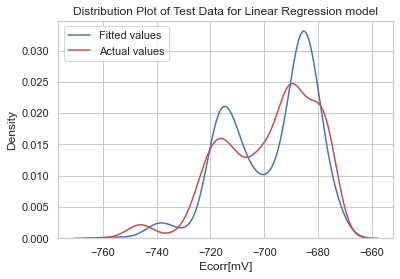

In [214]:
ax1 = sns.kdeplot(yhat_lm, color='b', label='Fitted values')
sns.kdeplot(y_test, color = 'r', label='Actual values', ax=ax1)
plt.title('Distribution Plot of Test Data for Linear Regression model')
plt.xlabel('Ecorr[mV]')
plt.legend()
plt.show()

## Lasso regression

Lasso regression did not perform well modeling the data. This would be ok having enough training data.

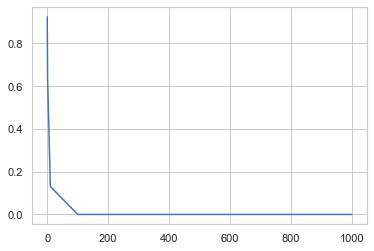

In [303]:
alpha = [0.0001, 0.001, 0.01, 1, 10, 100, 1000]
score_lasso = []

for i in alpha:
    lm_lasso = Lasso(alpha = i)
    lm_lasso.fit(X_train, y_train)
    score_lasso.append(lm_lasso.score(X_test, y_test))
    
plt.plot(alpha, score_lasso)

## Random Forest Regression

This model seems to perform well, this indication using desition three would be extremely beneficial on this set of data. This might be due to having multiple variables having a low correlation with the Ecorr value. Also, having many dependent variables with having 0 value seems using decision degree help to eliminate unnecessary variables.

In [212]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)
rf.score(X_test, y_test)

0.9995422219591829

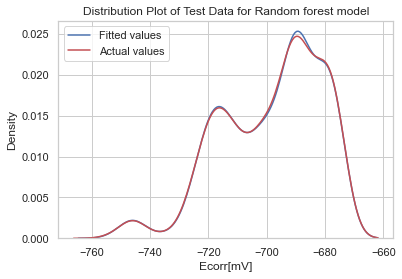

In [215]:
ax1 = sns.kdeplot(yhat_rf, color='b', label='Fitted values')
sns.kdeplot(y_test, color = 'r', label='Actual values', ax=ax1)
plt.title('Distribution Plot of Test Data for Random forest model')
plt.xlabel('Ecorr[mV]')
plt.legend()
plt.show()

## Grid search on random forest model

It seems Grid search did not help that much to improve the performance of the model even decreased the R-value slightly

In [218]:
param = {'n_estimators': range(10, 100, 10), 'criterion': ('mse', 'mae'), 'max_features' : ('auto', 'sqrt', 'log2')}
gs = GridSearchCV(rf, param)

In [219]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 100, 10)})

In [220]:
gs.best_score_

0.9983910830221963

In [222]:
gs.best_params_

{'criterion': 'mse', 'max_features': 'auto', 'n_estimators': 30}

In [224]:
gs_model = gs.best_estimator_

In [225]:
gs_yhat = gs_model.predict(X_test)

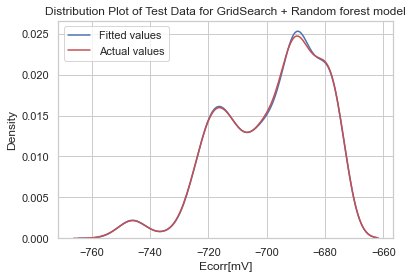

In [226]:
ax1 = sns.kdeplot(gs_yhat, color='b', label='Fitted values')
sns.kdeplot(y_test, color = 'r', label='Actual values', ax=ax1)
plt.title('Distribution Plot of Test Data for GridSearch + Random forest model')
plt.xlabel('Ecorr[mV]')
plt.legend()
plt.show()

## Multiple polynomial regression 

Using multiple polynomial regression obviously caused overfitting on the train data and not a good performance on the test data

In [234]:
Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2)), ('mode', LinearRegression())]
pl_pipe = Pipeline(Input)
pl_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('mode', LinearRegression())])

In [235]:
pl_pipe.score(X_test, y_test)

-337.8743959552925

In [236]:
pl_pipe.score(X_train, y_train)

0.9950201321378944

In [247]:
pl_pipe_yhat = pl_pipe.predict(X_test)

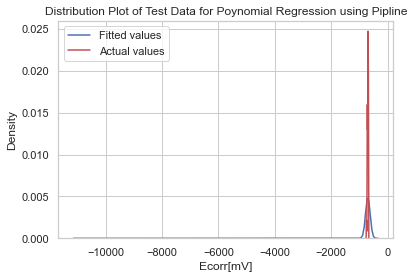

In [252]:
ax1 = sns.kdeplot(pl_pipe_yhat, color='b', label='Fitted values')
sns.kdeplot(y_test, color = 'r', label='Actual values', ax=ax1)
plt.title('Distribution Plot of Test Data for Poynomial Regression using Pipline')
plt.xlabel('Ecorr[mV]')
plt.legend()
plt.show()

## Ridge regression with multiple polynomial regression

Using ridge regression to find optimal varial for alpha to find the best model in polynomial regression. The value alpha 66 seems to give the best results. In general, multiple regression does not seem to give improvement modeling the data

In [272]:
pr = PolynomialFeatures(degree=2)
RR = Ridge()
X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)
parameters_RR = [{'alpha': range(1, 100, 5),'normalize':[True,False]}]
Grid = GridSearchCV(RR, parameters_RR)

In [273]:
Grid.fit(X_train_pr, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid=[{'alpha': range(1, 100, 5),
                          'normalize': [True, False]}])

In [274]:
Grid.best_estimator_

Ridge(alpha=66)

In [275]:
Grid_yhat = Grid.predict(X_test_pr)

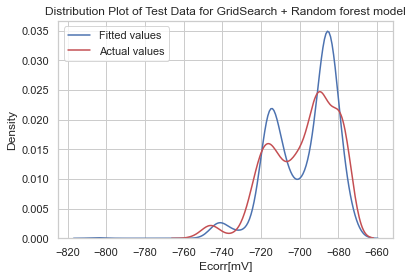

In [276]:
ax1 = sns.kdeplot(Grid_yhat, color='b', label='Fitted values')
sns.kdeplot(y_test, color = 'r', label='Actual values', ax=ax1)
plt.title('Distribution Plot of Test Data for GridSearch + Random forest model')
plt.xlabel('Ecorr[mV]')
plt.legend()
plt.show()

## Calculating mean absolute error for all of the models

As expected random forest having the best performance modeling the test data having the lowest mean absolute error

In [277]:
Grid.score(X_test_pr, y_test)

0.9200736859746225

In [281]:
mean_absolute_error(y_test, yhat_lm)

3.6810693304515576

In [282]:
mean_absolute_error(y_test, yhat_rf)

0.18701643000973492

In [283]:
mean_absolute_error(y_test, gs_yhat)

0.19464174513235577

In [284]:
mean_absolute_error(y_test, pl_pipe_yhat)

11.332563477299052

In [285]:
mean_absolute_error(y_test, Grid_yhat)

3.404242704604009

## Save the model

model are saved

* multiple linear regression
* random forest 
* multiple polynomial regression

**random forest** will be used for predicting the Ecorr value

In [290]:
with open('general_Ecorr_multipleLinearModel', 'wb') as f:
    pickle.dump(lm, f)

In [291]:
with open('general_Ecorr_randomForestModel', 'wb') as f:
    pickle.dump(rf, f)

In [292]:
with open('general_Ecorr_multiplePolynomialModel', 'wb') as f:
    pickle.dump(Grid, f)

## Future works

* model the graph values of comps
* model the microstructure